In [82]:
import tensorflow as tf
import numpy as np
import pandas as pd

import shutil
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import cv2 as cv
from IPython import display

In [83]:
PATH_org = "./Dataset"
PATH_Test_org = PATH_org+"/Testing_Data"

PATH = "./mydataset"
PATH_Train = PATH+"/train"
PATH_Test = PATH+"/test"

In [84]:
if not os.path.exists(PATH):
    os.makedirs(PATH)
    os.makedirs(PATH_Train)
    os.makedirs(PATH_Test)

# shutil.rmtree('/kaggle/working/mydataset/test')
# os.makedirs('/kaggle/working/mydataset/test')

In [85]:
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']
cnt = 0
for cat in categories:
    inp_path = os.path.join(PATH_org,"Training_Data", cat, "Masked_Train")
    re_path = os.path.join(PATH_org,"Training_Data", cat, "Unmasked_Train")

    # get list of all images in the folder
    inp_img = os.listdir(inp_path)
    re_img = os.listdir(re_path)
    # remove "masked_info.csv" from inp_img
    inp_img.remove("masked_info.csv")

    print(cat, len(inp_img), len(re_img))

    # merge two images and save it to the destination folder
    for i in range(len(inp_img)):
        img1 = plt.imread(os.path.join(inp_path, inp_img[i]))
        img2 = plt.imread(os.path.join(re_path, re_img[i]))
        img = np.concatenate((img2, img1), axis=1)

        if inp_img[i][-4:]=='jpeg':
            plt.imsave(os.path.join(PATH_Train, inp_img[i]), img)
            # print(os.path.join(PATH+"/train", inp_img[i]))
        else:
            plt.imsave(os.path.join(PATH_Train, inp_img[i][:-3]+'jpeg'), img)
            # print(os.path.join(PATH+"/train", inp_img[i][:-3]+'jpeg'))
            cnt+=1
        # break
    # break
print(cnt)

Cat 1750 1750
Dog 1750 1750
Elephant 1750 1750
Tiger 1750 1750
273


In [86]:
test_imgs = os.listdir(PATH_Test_org)
test_imgs.remove("masked_info.csv")
print(len(test_imgs))

cnt = 0
for i in range(len(test_imgs)):
    t_img = plt.imread(os.path.join(PATH_Test_org, test_imgs[i]))
    img = np.concatenate((t_img, t_img), axis=1)
    if test_imgs[i][-3:]=='png':
        plt.imsave(os.path.join(PATH_Test, test_imgs[i][:-3]+'jpeg'), img)
        cnt+=1
    else:
        plt.imsave(os.path.join(PATH_Test, test_imgs[i]), img)

print(cnt)

200
1


In [87]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

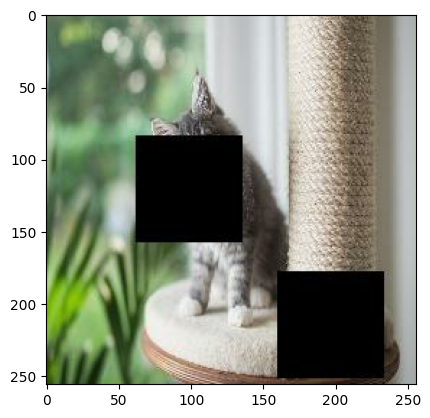

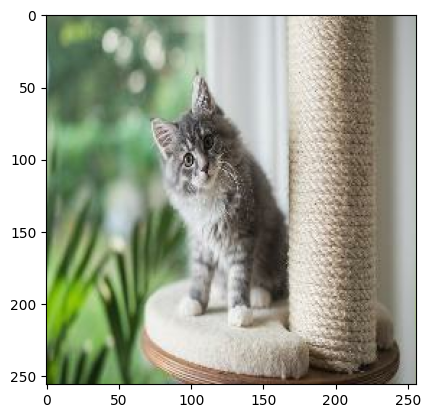

In [88]:
inp, re = load(str(PATH_Train +'/Cat-Train (1).jpeg'))

# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [89]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [90]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [91]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [92]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [93]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [94]:
# plt.figure(figsize=(6, 6))
# for i in range(4):
#   rj_inp, rj_re = random_jitter(inp, re)
#   plt.subplot(2, 2, i + 1)
#   plt.imshow(rj_inp / 255.0)
#   plt.axis('off')
# plt.show()

In [95]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [96]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [98]:
# regex for all image files in folder
train_dataset = tf.data.Dataset.list_files(str(PATH_Train+'/*.jpeg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [99]:
test_dataset = tf.data.Dataset.list_files(str(PATH_Train + '/*.jpeg'))

# choose only 20% of the test_dataset
num_files = tf.data.experimental.cardinality(test_dataset).numpy()
subset_size = int(0.2 * num_files)
test_dataset = test_dataset.shuffle(buffer_size=num_files, reshuffle_each_iteration=True)
test_dataset = test_dataset.take(subset_size)

test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [100]:
try:
  result_dataset = tf.data.Dataset.list_files(str(PATH_Test + '/*.jpeg'))
except tf.errors.InvalidArgumentError:
  result_dataset = tf.data.Dataset.list_files(str(PATH_Test + '/*.jpeg'))

result_dataset = result_dataset.map(load_image_test)
result_dataset = result_dataset.batch(BATCH_SIZE)

In [101]:
OUTPUT_CHANNELS = 3

In [102]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.01)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [28]:
down_model = downsample(3, 4)
# print(tf.expand_dims(inp, 0))
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [103]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.01)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [104]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [105]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.01)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

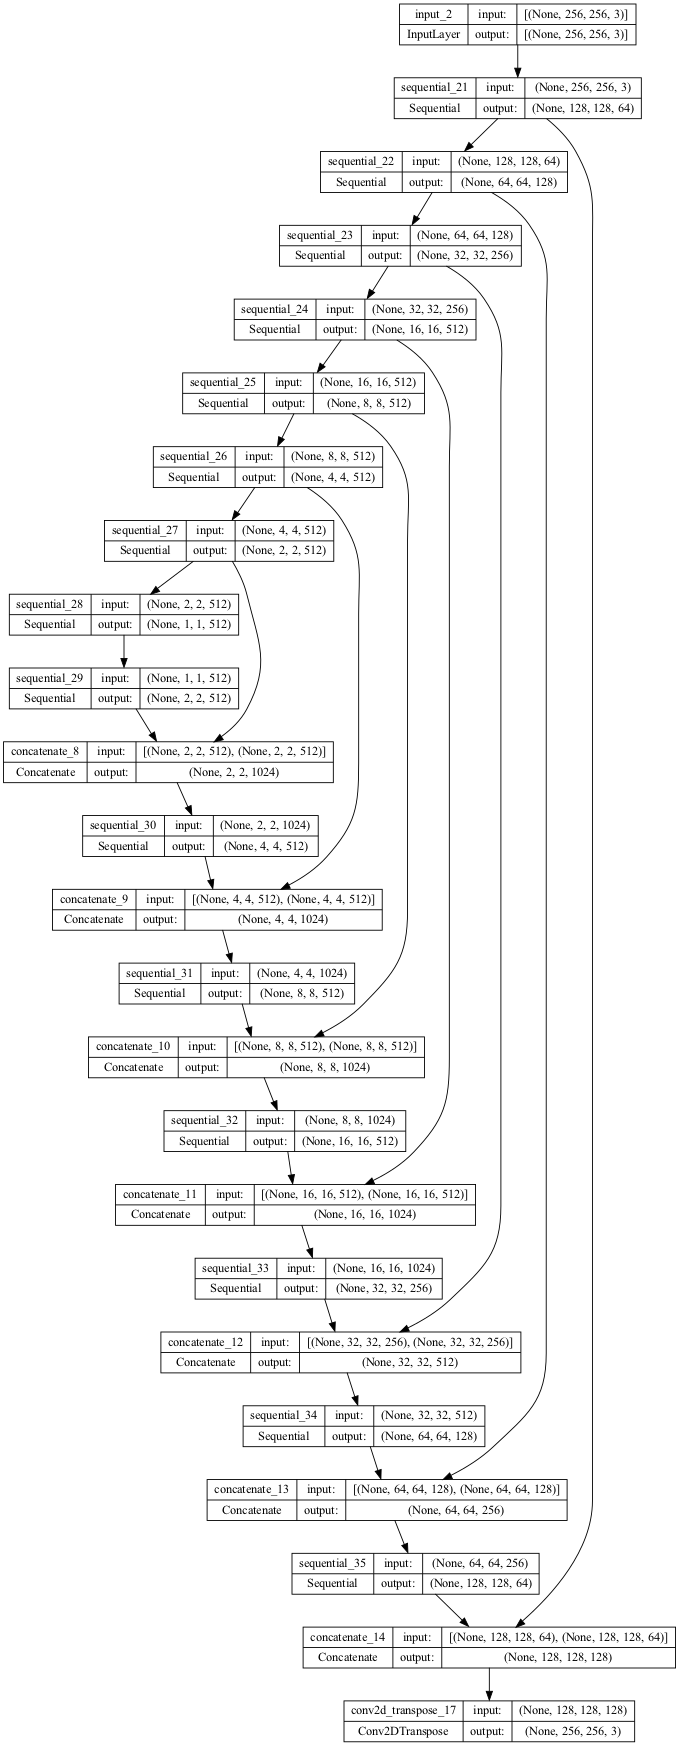

In [106]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


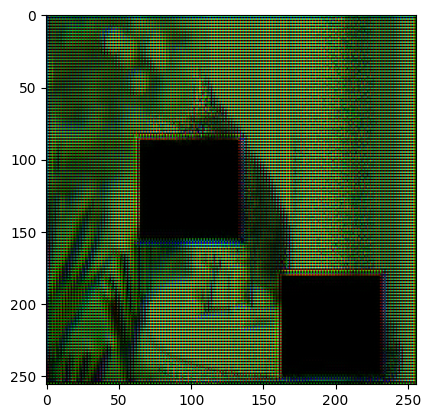

In [108]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [109]:
LAMBDA = 100

In [110]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [111]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [112]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.01)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

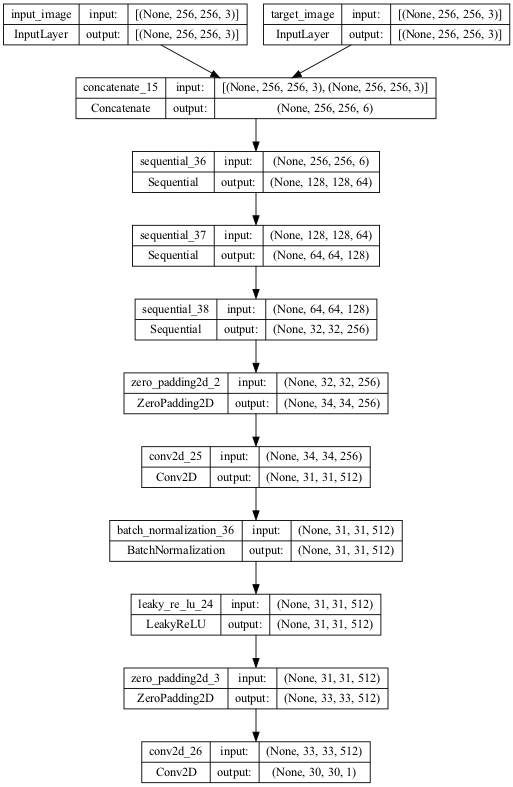

In [113]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

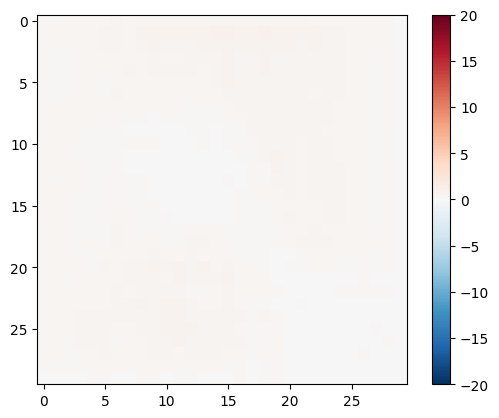

In [114]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [115]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [116]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [117]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [118]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

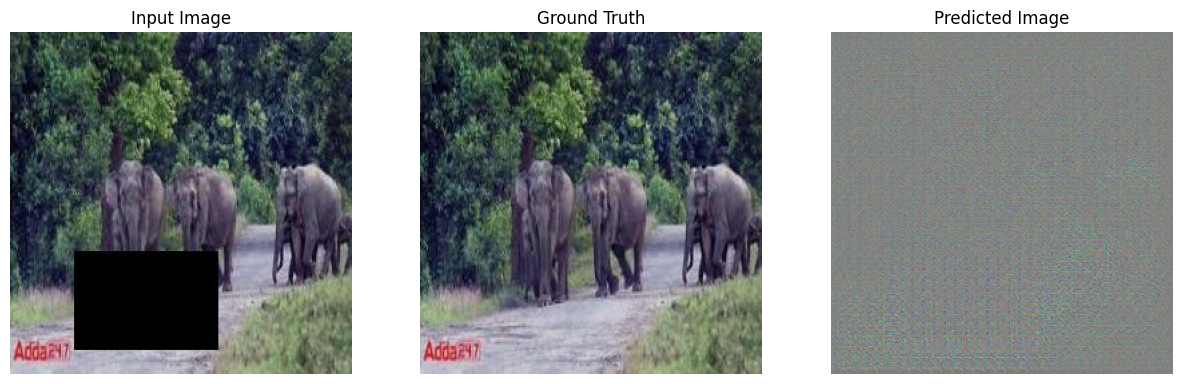

In [119]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [120]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [121]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//700)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//700)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//700)
    tf.summary.scalar('disc_loss', disc_loss, step=step//700)

In [122]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  print("Fit done!!")

In [123]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
fit(train_dataset, test_dataset, steps=40000)

In [43]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

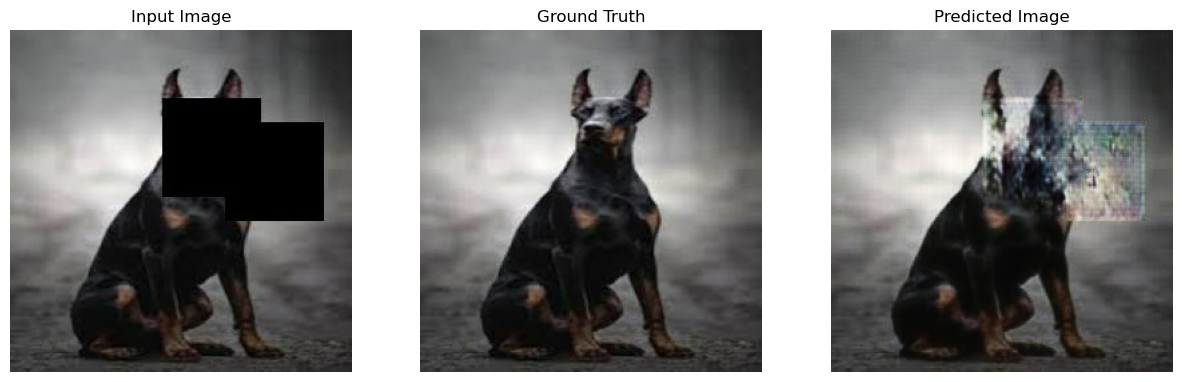

In [44]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(1):
  generate_images(generator, inp, tar)

In [45]:
img_dir = PATH_org+"/Testing_Data/"
csv_path = PATH_Test_org+"/masked_info.csv"
output_csv = "./output.csv"

test_mask_data = pd.read_csv(csv_path).drop(['Unnamed: 0'],axis=1)

In [46]:
with open(csv_path, 'r') as f:
    lines = f.readlines()
    submission = []
    for i, line in enumerate(lines[1:]):
        flag = 0
        filename, y1, x1, y2, x2 = test_mask_data.loc[i,]
        # print("Filename:",filename,end='\t')
        if filename[-3:] == 'png':
            filename = filename[:-3]+'jpeg'
            # print("New filename:",filename)
            flag = 1
        
        line = line.strip().split(',')
        print(line)
#         img = Image.open(img_dir + line[1])
#         plt.imshow(img)
#         plt.show()
        
        res_dataset = tf.data.Dataset.list_files(str(PATH_Test +"/"+ filename))
        res_dataset = res_dataset.take(1)
        res_dataset = res_dataset.map(load_image_test)
        res_dataset = res_dataset.batch(BATCH_SIZE)
        
        pred = None
        for inp, tar in res_dataset:
          prediction = generator(inp, training=True)
#           plt.figure(figsize=(15, 15))
          
          pred = np.array(prediction[0])
#           pred = pred.astype(np.uint8)
#           pred = Image.fromarray(pred)

#           display_list = [inp[0], tar[0], prediction[0]]
#           title = ['Input Image', 'Ground Truth', 'Predicted Image']

#           for i in range(3):
#               plt.subplot(1, 3, i+1)
#               plt.title(title[i])
#               # Getting the pixel values in the [0, 1] range to plot.
#               plt.imshow(display_list[i] * 0.5 + 0.5)
#               plt.axis('off')
#           plt.show()
          
#           plt.imshow(pred)
#           plt.show()

        img = np.array(pred)
        img = (img+1)/(2.0)
#         print("\nimg\n", img)
        b = img[:,:,0]
        g = img[:,:,1]
        r = img[:,:,2]
        if flag==1:
            filename = filename[:-4]+'png'
            # print("New filename:",filename)
            
        for i in range(y1 , y1+75):
            for j in range(x1, x1+75):
                temp1 = filename + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', b[i,j]))
                submission.append((temp1 + '1', g[i,j]))
                submission.append((temp1 + '2', r[i,j]))
        for i in range(y2 , y2+75):
            for j in range(x2, x2+75):
                temp1 = filename + '_' + 'box2' + '_' + str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', b[i,j]))
                submission.append((temp1 + '1', g[i,j]))
                submission.append((temp1 + '2', r[i,j]))
        df = pd.DataFrame(submission, columns=['filename_box_pixel','value'])
#         break

df.to_csv(output_csv, index=False)
print(df.shape)
print("File Saved")

Filename: Tiger (1024).jpeg
['0', 'Tiger (1024).jpeg', '58', '27', '104', '15']
Filename: Elephant-Train (1195).jpeg
['1', 'Elephant-Train (1195).jpeg', '92', '38', '98', '94']
Filename: Tiger (980).jpeg
['2', 'Tiger (980).jpeg', '12', '116', '42', '33']
Filename: Elephant-Train (1842).jpeg
['3', 'Elephant-Train (1842).jpeg', '2', '77', '174', '174']
Filename: Dog-Train (1753).jpeg
['4', 'Dog-Train (1753).jpeg', '52', '75', '84', '160']
Filename: Cat-Train (1374).jpeg
['5', 'Cat-Train (1374).jpeg', '169', '149', '113', '153']
Filename: Cat-Train (61).jpeg
['6', 'Cat-Train (61).jpeg', '106', '165', '91', '21']
Filename: Tiger (1037).jpeg
['7', 'Tiger (1037).jpeg', '107', '44', '114', '175']
Filename: Tiger (1477).jpeg
['8', 'Tiger (1477).jpeg', '8', '37', '130', '60']
Filename: Cat-Train (24).jpg
['9', 'Cat-Train (24).jpg', '144', '157', '82', '129']
Filename: Elephant-Train (40).jpeg
['10', 'Elephant-Train (40).jpeg', '26', '131', '118', '41']
Filename: Tiger (1115).jpeg
['11', 'Tiger 

In [47]:
# os.remove("/kaggle/working/submission.csv")
# print("removed")